In [1]:
!git clone https://github.com/shucoll/GameTox.git


Cloning into 'GameTox'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 16 (delta 2), reused 9 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 839.75 KiB | 9.88 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [2]:
!ls GameTox


gametox.csv  README.md


In [3]:
import pandas as pd

df = pd.read_csv("/content/GameTox/gametox.csv")
print("Total rows:", len(df))
df.head()


Total rows: 53704


,message,label
0,hey Team mates - are you playing with me?????,0.0
1,move your ace plebs,1.0
2,nice,0.0
3,thanks KPZ,0.0
4,sry,0.0


In [4]:
print(df.columns)
print(df['label'].value_counts())


Index(['message', 'label'], dtype='object')
label
0.0    43497
1.0     7407
2.0     2343
3.0      349
4.0       75
5.0       30
Name: count, dtype: int64


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/GameTox/gametox.csv")

df = df.dropna(subset=['label'])

def map_labels(x):
    if x == 0:
        return 'neutral'
    elif x in [1, 2]:
        return 'negative'
    else:
        return 'derogatory'

df['label'] = df['label'].apply(map_labels)

print("Label distribution:\n", df['label'].value_counts())

train_val_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)

train_df, val_df = train_test_split(
    train_val_df, test_size=0.125, stratify=train_val_df['label'], random_state=42
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain labels:\n", train_df['label'].value_counts())
print("\nValidation labels:\n", val_df['label'].value_counts())
print("\nTest labels:\n", test_df['label'].value_counts())


Label distribution:
 label
neutral       43497
negative       9750
derogatory      454
Name: count, dtype: int64
Train size: 37590
Validation size: 5370
Test size: 10741

Train labels:
 label
neutral       30447
negative       6825
derogatory      318
Name: count, dtype: int64

Validation labels:
 label
neutral       4350
negative       975
derogatory      45
Name: count, dtype: int64

Test labels:
 label
neutral       8700
negative      1950
derogatory      91
Name: count, dtype: int64


In [7]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer

def clean_text(text):
    """
    Lowercase, remove special chars/numbers, extra spaces.
    """
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

slang_dict = {
    'gg': 'good game',
    'wp': 'well played',
    'ez': 'easy',
    'noob': 'newbie',
    'ezpz': 'easy',
    'omg': 'oh my god',
    'wtf': 'what the fuck',
    'ffs': 'for fucks sake',
    'ggwp': 'good game well played'
}

def normalize_slang(text):
    for slang, replacement in slang_dict.items():
        text = re.sub(r'\b' + re.escape(slang) + r'\b', replacement, text)
    return text


for df_split in [train_df, val_df, test_df]:
    df_split['clean_text'] = df_split['message'].apply(clean_text)
    df_split['clean_text'] = df_split['clean_text'].apply(normalize_slang)

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)
X_train = vectorizer.fit_transform(train_df['clean_text'])
X_val = vectorizer.transform(val_df['clean_text'])
X_test = vectorizer.transform(test_df['clean_text'])

y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']


print("TF-IDF shape (train):", X_train.shape)
print("TF-IDF shape (val):", X_val.shape)
print("TF-IDF shape (test):", X_test.shape)
print("\nExample feature names:", vectorizer.get_feature_names_out()[:20])


TF-IDF shape (train): (37590, 5000)
TF-IDF shape (val): (5370, 5000)
TF-IDF shape (test): (10741, 5000)

Example feature names: ['aa' 'aaa' 'able' 'able to' 'about' 'absolute' 'abuwinni' 'ac' 'acc'
 'accept' 'accept platoon' 'account' 'accuracy' 'ace' 'across' 'active'
 'actually' 'ae' 'ae phase' 'af']


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Set Performance:

              precision    recall  f1-score   support

  derogatory     0.3750    0.1333    0.1967        45
    negative     0.8008    0.6103    0.6927       975
     neutral     0.9102    0.9648    0.9367      4350

    accuracy                         0.8935      5370
   macro avg     0.6953    0.5695    0.6087      5370
weighted avg     0.8859    0.8935    0.8862      5370



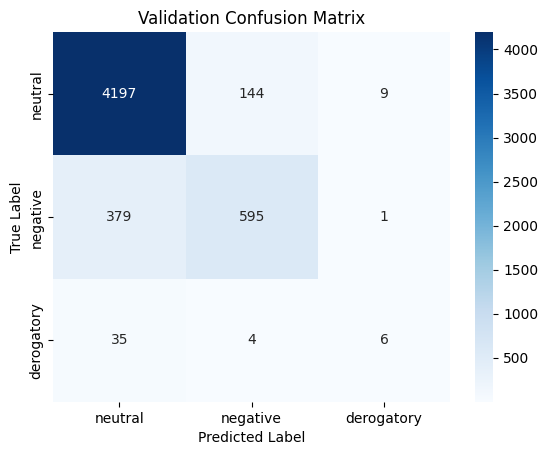

Test Set Performance:

              precision    recall  f1-score   support

  derogatory     0.3902    0.1758    0.2424        91
    negative     0.8218    0.6195    0.7064      1950
     neutral     0.9150    0.9707    0.9420      8700

    accuracy                         0.9002     10741
   macro avg     0.7090    0.5887    0.6303     10741
weighted avg     0.8936    0.9002    0.8933     10741



In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_weights = {
    'neutral': 1,
    'negative': 1.5,
    'derogatory': 5
}


clf = LogisticRegression(
    max_iter=1000,
    class_weight=class_weights,
    solver='lbfgs',
    multi_class='multinomial'
)

clf.fit(X_train, y_train)


y_val_pred = clf.predict(X_val)
print("Validation Set Performance:\n")
print(classification_report(y_val, y_val_pred, digits=4))


cm = confusion_matrix(y_val, y_val_pred, labels=['neutral', 'negative', 'derogatory'])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['neutral', 'negative', 'derogatory'],
            yticklabels=['neutral', 'negative', 'derogatory'], cmap='Blues')
plt.title("Validation Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

y_test_pred = clf.predict(X_test)
print("Test Set Performance:\n")
print(classification_report(y_test, y_test_pred, digits=4))


In [9]:
!pip install gradio


In [10]:
def classify_message(message):

    text = clean_text(message)

    text = normalize_slang(text)

    X = vectorizer.transform([text])

    pred = clf.predict(X)[0]
    return pred


In [12]:
import gradio as gr


demo = gr.Interface(
    fn=classify_message,
    inputs=gr.Textbox(label="Enter Chat Message"),
    outputs=gr.Label(label="Sentiment")
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3614669c46124b1b57.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
